# Five-Bar Jumping Frog
By: Michael Gross and Jacob Pisors\
Developed for RAS 557 - Foldable Robotics

## Import Libraries

In [6]:
# INSTALL CUSTOM MUJOCO LIBRARY:
# (Uncomment the following lines to install)
# !git clone  https://github.com/MGross21/MujocoHandler

In [7]:
import sys
import os

# Get the path of the grandparent directory (two levels up)
grandparent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

# Append the grandparent directory to the system path
sys.path.append(grandparent_dir)

# Import Custom Class
from MujocoHandler.MujocoHandler import MujocoHandler

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import math
import mujoco
import xml.etree.ElementTree as ET

## Define XML Template

In [9]:
with open("frogModel.xml", 'r', encoding='utf-8') as file:
    xml_template = file.read()

## Define Simulation Constants
### Motor Constants

In [10]:
Vnom = 6
G = 55.5
t_stall = 15/100/G
i_stall = .6
R = Vnom/i_stall
i_nl = .2
w_nl = .66*1000*math.pi/180*G

kt = t_stall/ i_stall
# kv= Vnom/w_nl
ke = kt

b_calc = kt*i_nl/w_nl


V_control = 5

b_fit = 1.404e-6
# kp_fit = 8.896

kp_fit = 20

### Simulation Parameter Constants

In [11]:
render_width = 800
render_height = 600

duration = 10
framerate = 30 # (Hz)
data_rate = 100
ts = 1e-4

CONTROL_TIME = 2 # Used to trigger actuators and to truncate settling time
DATA_TRUNCATE = int(CONTROL_TIME*data_rate)
RUN_OPTIMIZER = False # Enable or Disable Scipy Optimize

### Frog-Based Design Constants

In [12]:
IN_TO_M = 0.0254  # Upscale to fix simulation issues at small rendering

TOTAL_FROG_MASS = 0.045 # kg
BACK_LEG_MASS = 0.008 # kg PER LEG


leg_width = 1 * IN_TO_M
TOTAL_LEG_LENGTH = 11 * IN_TO_M
leg_thickness = 0.1 * IN_TO_M 
leg_segment_mass = BACK_LEG_MASS/6 # kg

front_leg_height = TOTAL_LEG_LENGTH/10

body_mass = TOTAL_FROG_MASS - 2*BACK_LEG_MASS #kg

### Controller Design

In [13]:
stepUpTime = 0.35
stepDownTime = 1

stepLowValue = 0
stepHighValue = math.pi

In [14]:
def generate_step_wave(time, up_time, down_time, low_value, high_value):

    cycle_position = time % (up_time + down_time)  # Position within the current cycle

    # Return high or low value based on up/down times
    return high_value if cycle_position < up_time else low_value

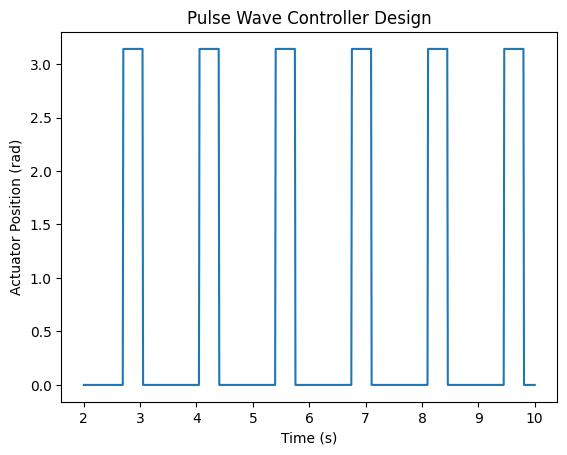

In [147]:
timeArr = np.linspace(0,duration,num=1000)
out_wave = [generate_step_wave(time,stepUpTime,stepDownTime,stepLowValue,stepHighValue) for time in timeArr]
out_wave = out_wave[DATA_TRUNCATE:]

timeArr = timeArr[len(timeArr) - len(out_wave):]

plt.plot(timeArr,out_wave)
plt.xlabel("Time (s)")
plt.ylabel("Actuator Position (rad)")
plt.title("Pulse Wave Controller Design",loc="Center")
plt.savefig("Figures/PulseWaveController.png")

## Definiting Simulation Run Sequence
### Frog Specific Class Method

In [16]:
class Frog(MujocoHandler):
    def __init__(self, xml, duration=10, fps=30, width=400, height=300, initConditions=None):
        # Initialize the base MujocoHandle
        super().__init__(xml, duration, fps, width, height, initConditions)

        # Set a default controller to the frog's jump logic
        self.setController(self.jumpController)

    def jumpController(self, model, data):
        """Custom controller logic"""
        
        num_act = model.nu  # Number of actuators

        kp_fits = [kp_fit] * num_act  # Proportional gain expanded

        desired_positions = num_act*[generate_step_wave(time=data.time, 
                                                        up_time=stepUpTime,
                                                        down_time=stepDownTime, 
                                                        low_value=stepLowValue, 
                                                        high_value=stepHighValue)] 


        V_controls = [V_control] * num_act

        for i in range(num_act):
            # Current state
            w = data.qvel[i]  # Current velocity
            actual = data.qpos[i]  # Current position
            desired = desired_positions[i]  # Desired position

            # Control logic
            error = desired - actual
            V = kp_fits[i] * error 
            V = max(min(V, V_controls[i]), -V_controls[i])  # Clamp voltage

            # Torque calculation
            torque = (kt * (V - (ke) * w * G) / R - b_fit * w * G) * G

            # Apply alternating torque signs
            if i % 2 == 0:  # Positive torque for even-indexed actuators
                data.ctrl[i] = torque
            else:  # Negative torque for odd-indexed actuators
                # data.ctrl[i] = -torque
                pass

        return

### Joint Angle Initial Condition Parameterization

In [17]:
def compute_exterior_angles(side_lengths):
    n = len(side_lengths)
    angles = []
    total_angle = 2 * np.pi  # Sum of exterior angles in radians
    remaining_angle = total_angle
    
    for i in range(n):
        if i == n - 1:  # Last angle
            angles.append(remaining_angle)
        else:
            # Proportionally divide angles based on side lengths
            angle = (side_lengths[i] / sum(side_lengths)) * total_angle
            angles.append(angle)
            remaining_angle -= angle
    
    return angles

### Formatting XML Template and Initiating Mujoco

In [18]:
def run_sim(params,render=False):
        
        try:
                k,a_len,b_len,c_len,d_len,e_len = params

                total_leg_length = sum((a_len,b_len,c_len,d_len,e_len))


                model_format = {
                                # SPRING / DAMPING 
                                'k':    k,
                                'b':    k/100,

                                # BACK LEG LENGTHS (HALF LENGTHS)
                                'a_len':                a_len/2, 
                                'b_len':                b_len/2, 
                                'c_len':                c_len/2, 
                                'd_len':                d_len/2,
                                'e_len':                e_len/2,

                                # BACK LEG SIMULATION OFFSETS 
                                'b_off':                a_len, 
                                'c_off':                b_len, 
                                'd_off':                c_len,
                                'e_off':                d_len,
                                'a_off':                e_len,

                                # BACK LEG MISC
                                'leg_thickness':        leg_thickness,
                                'leg_width':            leg_width/2,
                                'leg_segment_mass':     leg_segment_mass,

                                #BODY AND FRONT LEGS
                                'front_leg_height':     front_leg_height,
                                'body_mass':            body_mass,
                                'body_width':           leg_thickness*20,
                                'body_length':          (total_leg_length - a_len)/2,

                                # SPAWN SETTINGS
                                'body_z_spawn':         total_leg_length,
                                'body_x_spawn':         -total_leg_length/2,

                                # RENDER AND SIMULATION DETAILS
                                'ts' :                  ts, 
                                'render_width' :        render_width, 
                                'render_height' :       render_width
                        }
                


                ### EXTRA -- DYNAMIC PARAMETERS###
                model_format['leg_offset_from_body']    =       6*leg_thickness + model_format['body_width'] # leg thickness plus body width
                model_format['front_leg_x']             =       model_format['body_length'] * 2

                
                ### FORMAT SIMULATION XML
                xml = xml_template.format(**model_format)
                # print(model_format)
                # print(xml)
                
                ### SET SIMULATION INITIAL CONDITIONS
                qpos_init = compute_exterior_angles([a_len,b_len,c_len,d_len,e_len])
                
                ic = {
                        "qpos": [0,0] + qpos_init * 2 # [z pris, x pris] +  [LEFT A,B,C,D,E] + [RIGHT A,B,C,D,E] 
                } 

                ### CALL CLASS SIM OBJECT
                
                return Frog (xml=xml, 
                            initConditions=ic,
                            duration=duration,
                            width=render_width,
                            height=render_height
                        )\
                        .runSim(render=render,
                                 data_rate=data_rate,
                                 camera="frog_cam")
        
        except Exception as e:
                print(f"An error occurred: {e}")

## Arbitrary Design Test

In [19]:
# frogData,model,data,showPixels,renderMedia
frogModel = run_sim(                            (0.1, #k
                                                2*IN_TO_M,              #A
                                                2*IN_TO_M,        #B
                                                2*IN_TO_M,           #C 
                                                2*IN_TO_M,            #D
                                                2*IN_TO_M),           #E
                                                render=True      )
frogModel

MujocoHandler(
  Duration: 10 [30 fps, timestep = 1e-04]
  Gravity: [ 0.    0.   -9.81],
  Resolution: 800x600
  Bodies (17): world, frog_body, front_leg_left, front_leg_right, A_left, B_left, C_left, D_left, E_left, Ap_left, A_right, B_right, C_right, D_right, E_right, Ap_right, floor
  Joints (12): x_axis, z_axis, jointB_left, jointC_left, jointD_left, jointE_left, jointAp_left, jointB_right, jointC_right, jointD_right, jointE_right, jointAp_right
  Actuators (4): FR, BR, FL, BL
  Initial Conditions: {'qpos': [0, 0, 1.2566370614359172, 1.2566370614359172, 1.2566370614359172, 1.2566370614359172, 1.2566370614359172, 1.2566370614359172, 1.2566370614359172, 1.2566370614359172, 1.2566370614359172, 1.2566370614359172]}
  Controller Enabled: True
)


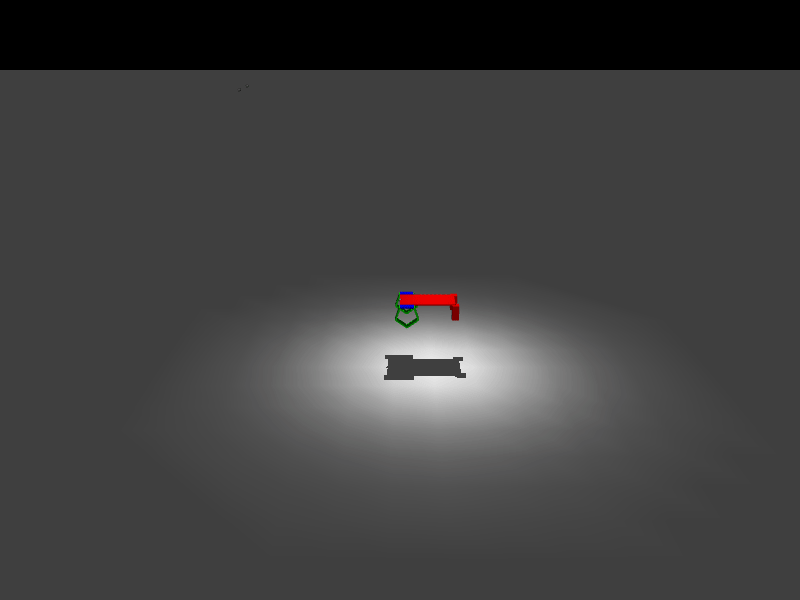

Media saved to FrogArbitrary.mp4


In [20]:
frogModel.renderMedia()
frogModel.renderMedia(codec="mp4",title="FrogArbitrary",save=True)

In [21]:
# Find Joint Indexes

joint_names = ["jointB_left", "jointC_left", "jointD_left", "jointE_left", "jointAp_left", "jointB_right", "jointC_right", "jointD_right", "jointE_right", "jointAp_right"]
act_names = ["jointB_left","jointAp_left", "jointB_right", "jointAp_right"]

joint_idxs = [mujoco.mj_name2id(frogModel.model, mujoco.mjtObj.mjOBJ_JOINT, name) for name in joint_names]
act_idxs = [mujoco.mj_name2id(frogModel.model, mujoco.mjtObj.mjOBJ_JOINT, name) for name in act_names]

joint_idxs, act_idxs

([2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [2, 6, 7, 11])

In [142]:
def plot_data(data_x, data_y, y_idxs, start_idx=0, xlabel="Time (s)", ylabel="Displacement", title="Joint Positions", legend=None):
    # Extract and truncate data
    truncated_data_x = data_x[start_idx:]  # Truncate data_x from start_idx
    truncated_data_y = data_y[start_idx:, y_idxs]  # Truncate data_y from start_idx and select y_idxs columns

    # Adjust data_y to be relative to the first value in each series
    relative_data_y = truncated_data_y - truncated_data_y[0, :]  # Subtract the first value of each column

    # Plot each series in relative_data_y
    for i, series_data in enumerate(relative_data_y.T):  # Iterate through each series (column)
        plt.plot(truncated_data_x, series_data, label=legend[i] if legend else f"Series {i+1}")

    # Add labels, title, and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, loc="center")
    if legend:
        plt.legend()

    # Show the plot
    plt.savefig(f"Figures/{title}.png")


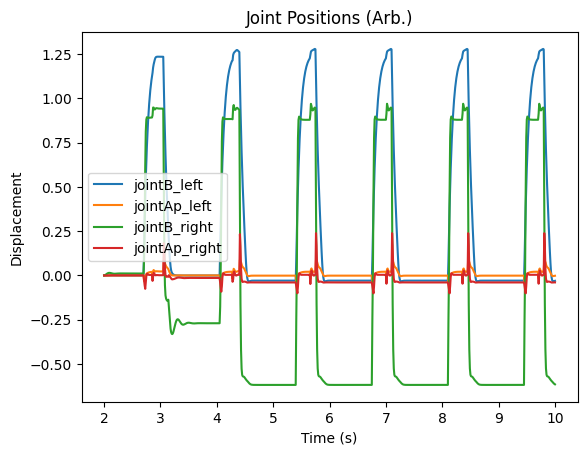

In [144]:
plot_data(
    data_x=frogModel.simData['time'],                     # Time data
    data_y=frogModel.simData['qpos'],                     # Full data array
    y_idxs=act_idxs,                      # Indices for columns to plot
    start_idx=DATA_TRUNCATE,                # Start index for truncation
    xlabel="Time (s)",
    ylabel="Displacement",
    title="Joint Positions (Arb.)",
    legend=act_names                        # Legend labels
)

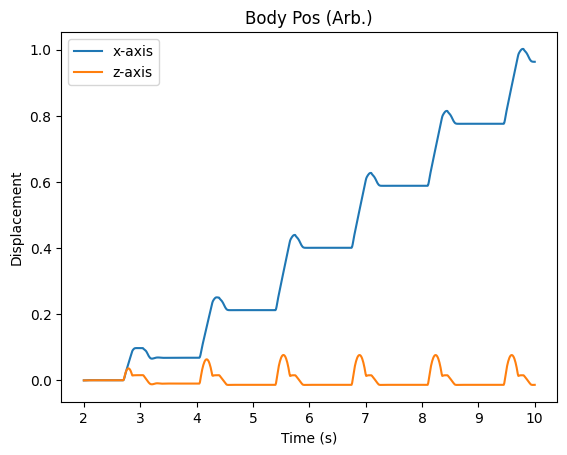

In [145]:
plot_data(
    data_x=frogModel.simData['time'],                     # Time data
    data_y=frogModel.simData['qpos'],                      # Full data array
    y_idxs=[0,1],                      # Indices for columns to plot
    start_idx=DATA_TRUNCATE,                # Start index for truncation
    xlabel="Time (s)",
    ylabel="Displacement",
    title="Body Pos (Arb.)",
    legend=["x-axis","z-axis"]                        # Legend labels
)

## Design Optimization
### Cost Function Definition

In [129]:
dists = []
kArr = []
leg_lengths = []

maxMag = 0
iterations = 0

def fun(params):
    ### RUN SIM ###

    global maxMag,iterations

    k = params[0]
    params[0] = k.item() if isinstance(k, np.ndarray) else k

    
    model = run_sim(params,render=False)


    ### GRAB DATA ##
    body_axis_names = ["x_axis","z_axis"]
    # body_idxs = [mujoco.mj_name2id(model.model, mujoco.mjtObj.mjOBJ_JOINT, name) for name in body_axis_names]

    x_positions = model.simData['qpos'][DATA_TRUNCATE:,0]
    z_positions = model.simData['qpos'][DATA_TRUNCATE:,1]

    x_max = np.max(x_positions,axis=0) - np.min(x_positions,axis=0)
    z_max = np.max(z_positions,axis=0) - np.min(z_positions,axis=0)

    mag_dist = np.sqrt(x_max**2 + z_max**2)

    if np.ceil(mag_dist) > maxMag:
        print(f"New Max: {maxMag} (Epoch {iterations})")
        maxMag = np.ceil(mag_dist)
    iterations+=1
    
    ## SAVE DATA ###
    dists.append(mag_dist)
    kArr.append(params[0])
    leg_lengths.append(params[1:])


    return (-mag_dist)

### Optimization Function

In [130]:
import scipy.optimize as so

ini_k = [0.1]
ini_leg_len = [2*IN_TO_M]*5  # A,B,C,D,E

x0 = ini_k + ini_leg_len

min_leg_length = 1.25
max_leg_length = 3

ts = 5e-3

length_bounds = (min_leg_length * IN_TO_M, max_leg_length * IN_TO_M)

bounds = [
    (1e-2, 1e2),  # stiffness (b = 1/100)
    *([length_bounds] * 5)  # a_len, b_len, c_len, d_len, e_len
]

if RUN_OPTIMIZER: # Enable to run simulations
    results = so.minimize(
        fun, 
        x0=x0,
        bounds=bounds,
        method='Nelder-Mead',  # SLSQP is suitable for problems with constraints
        options={'ftol': 1e-4, 'gtol': 1e-4}  # Correct options for SLSQP
    )
    results
    
ts = 1e-4

### Optimized Results

In [131]:
if RUN_OPTIMIZER:
    best_params = results.x
    best_params

### Save Results to `.csv`

In [132]:
folder_dir = "./data/Simulation/"

In [133]:
import pandas as pd
import datetime as dt
import os

if RUN_OPTIMIZER:

    data_out = np.column_stack((kArr, np.array(leg_lengths),dists))
    df = pd.DataFrame(data_out,columns=["Stiffness","A_len","B_len","C_len","D_len","E_len","XZ_Rel_Distance"])

    df_sorted = df.sort_values(by="XZ_Rel_Distance", ascending=False)

    if not os.path.exists(folder_dir):
        os.makedirs(folder_dir)

    name_out = "frog_" + dt.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
    df_sorted.to_csv(f"{folder_dir}{name_out}.csv", index=False)

### Re-Import Most Recent Data

In [134]:
import glob

file_exist_check = [file for _, _, files in os.walk(folder_dir) for file in files]

# # og files found
print(f"Saved Simulation Optimization Experiments: {len(file_exist_check)}")

# Print all file names
for count,file in enumerate(file_exist_check):
    print(f"{count+1}.\t{file}")

Saved Simulation Optimization Experiments: 1
1.	frog_11-28-2024_00-18-11.csv


In [135]:
# only run if experiments exist to be loaded
if file_exist_check:
    files = glob.glob(os.path.join(folder_dir, "*.csv"))

    most_recent_file = max(files, key=os.path.getmtime)

    df = pd.read_csv(most_recent_file)

    # Reassign Data Vars
    kArr = df['Stiffness'].to_numpy()
    leg_lengths = df[['A_len', 'B_len', 'C_len', 'D_len', 'E_len']].to_numpy()
    dists = df['XZ_Rel_Distance'].to_numpy()

    
    # max_row = df.loc[df['XZ_Rel_Distance'].idxmax()]
    top_five = df.nlargest(5, 'XZ_Rel_Distance')

    leg_params = df.drop(columns=["XZ_Rel_Distance"])

df.head()

Stiffness     A_len     B_len     C_len     D_len     E_len  \
0   0.056375  0.293415  0.274142  0.262195  0.355671  0.243479   
1   0.056374  0.293415  0.274135  0.262210  0.355680  0.243472   
2   0.056384  0.293393  0.274138  0.262223  0.355672  0.243476   
3   0.056375  0.293415  0.274141  0.262196  0.355671  0.243479   
4   0.056364  0.293411  0.274089  0.262314  0.355742  0.243417   

   XZ_Rel_Distance  
0        16.832159  
1         7.686741  
2         7.680991  
3         7.679721  
4         7.676600

In [136]:
best_params = leg_params.values[0] # grab value
best_params*2*(1/IN_TO_M) # Print conversion back to full length in for reference in physical design

array([ 4.43898234, 23.10356676, 21.58594783, 20.64531049, 28.00558586,
       19.1716084 ])

In [137]:
bestModel = run_sim(params=tuple(best_params.tolist()), render=True)

In [138]:
# bestModel.renderMedia(title="Best Model")
# bestModel.renderFrame(t=1.5)
bestModel.renderMedia(codec="mp4",title="Optimized_Model",save=True)

Media saved to Optimized_Model.mp4


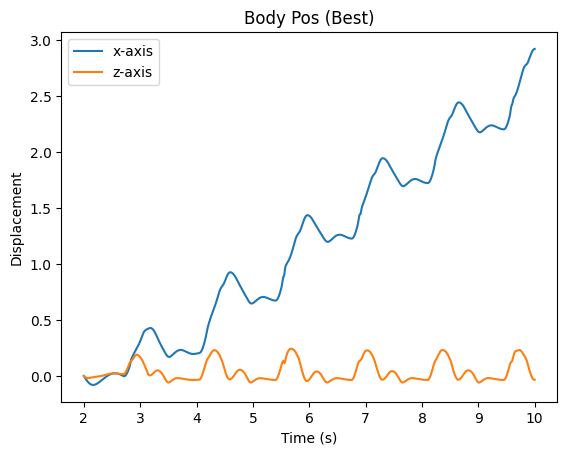

In [146]:
plot_data(
    data_x=bestModel.simData['time'],                     # Time data
    data_y=bestModel.simData['qpos'],                     # Full data array
    y_idxs=[0,1],                      # Indices for columns to plot
    start_idx=DATA_TRUNCATE,                # Start index for truncation
    xlabel="Time (s)",
    ylabel="Displacement",
    title="Body Pos (Best)",
    legend=["x-axis","z-axis"]                        # Legend labels
)

How K correlates with  distance

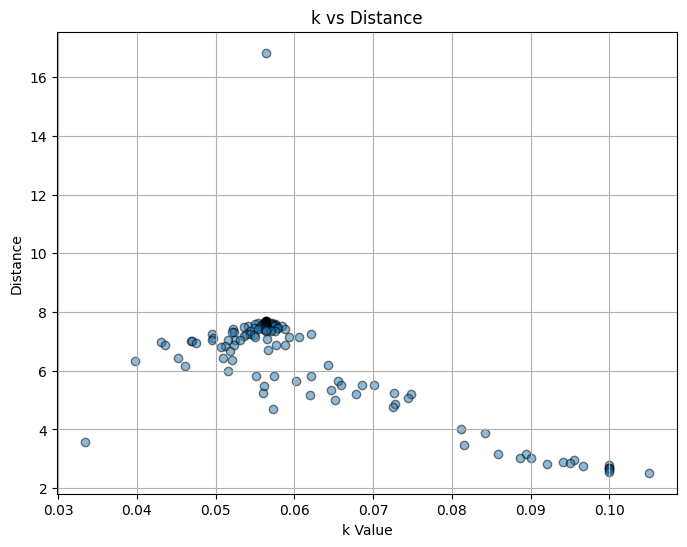

In [140]:
plt.figure(figsize=(8, 6))
plt.scatter(kArr[kArr<1], dists[kArr<1], edgecolor='k', alpha=0.5)
plt.xlabel("k Value")
plt.ylabel("Distance")
plt.title("k vs Distance")
plt.grid()
plt.savefig("Figures/stiffness_vs_distance.png")

How each leg correlates with dist

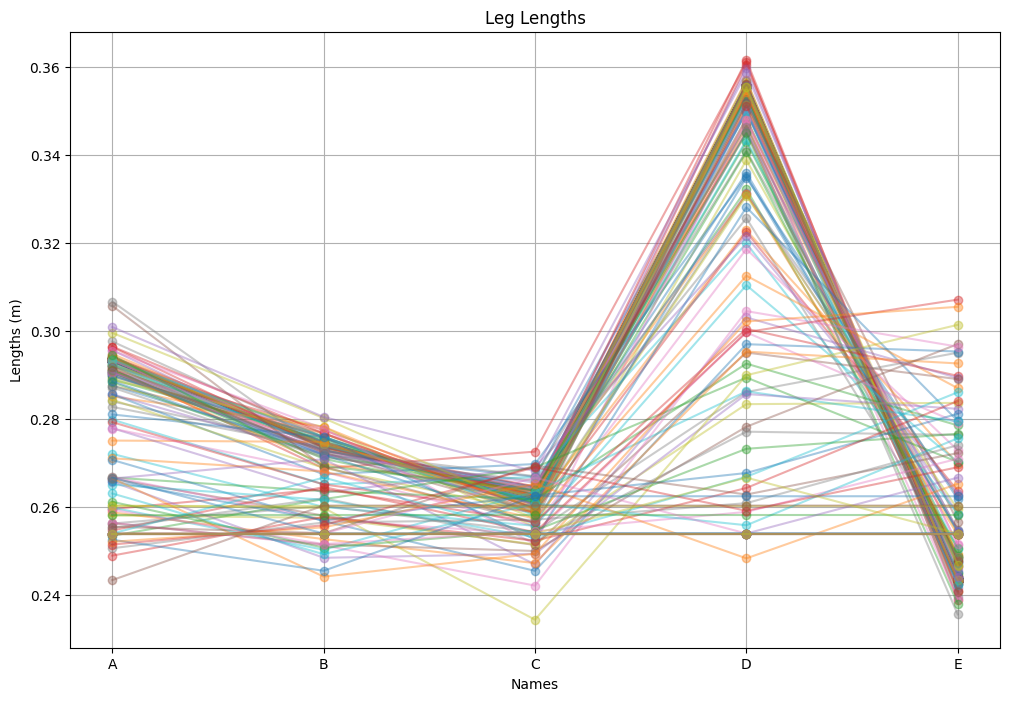

In [37]:
leg_names = ["A","B","C","D","E"]


plt.figure(figsize=(12, 8))
for i in range(leg_lengths.shape[0]):
    plt.plot(leg_names, leg_lengths[i, :], label=f"Experiment {i + 1}", marker='o', alpha=0.4)

plt.xlabel("Names")
plt.ylabel("Lengths (m)")
plt.title("Leg Lengths")
# plt.legend(loc="best")
plt.grid(True)
plt.show()

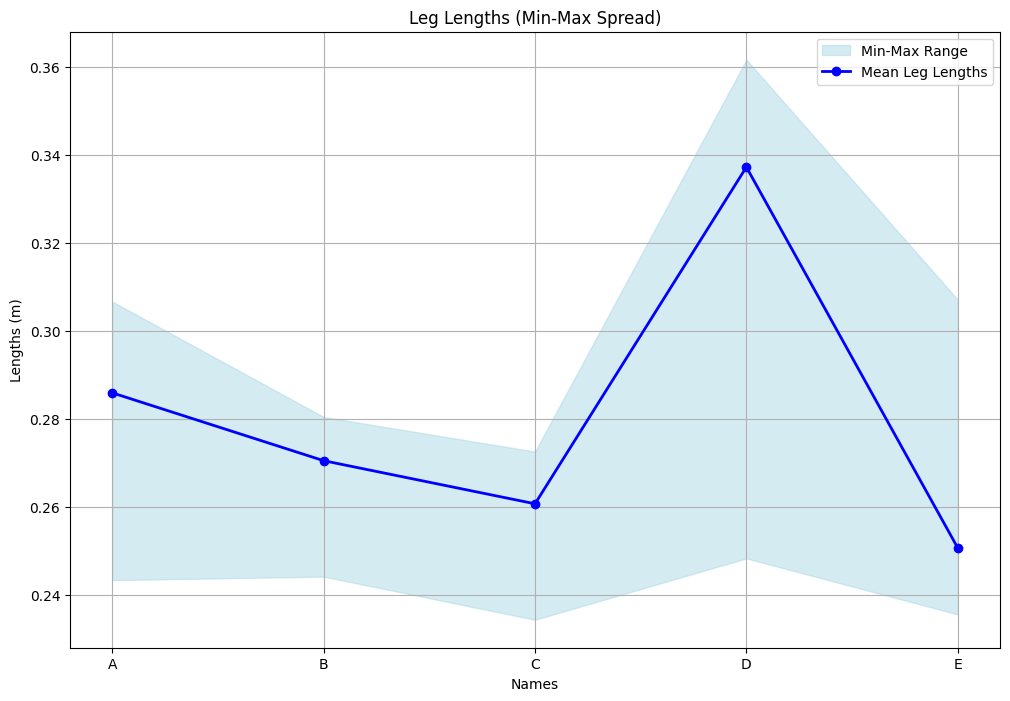

Leg Means:  [0.28595573 0.27054538 0.2607538  0.33725859 0.25072444]


In [38]:
# Calculate the min and max for each leg (column)
leg_min = np.min(leg_lengths, axis=0)
leg_max = np.max(leg_lengths, axis=0)
leg_mean = np.mean(leg_lengths, axis=0)  # Mean value for each leg length

plt.figure(figsize=(12, 8))

# Plot the shaded area between the min and max
plt.fill_between(leg_names, leg_min, leg_max, color='lightblue', alpha=0.5, label="Min-Max Range")

# Plot the mean of leg lengths
plt.plot(leg_names, leg_mean, color='blue', marker='o', label="Mean Leg Lengths", linewidth=2)

# Labels and title
plt.xlabel("Names")
plt.ylabel("Lengths (m)")
plt.title("Leg Lengths (Min-Max Spread)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

print("Leg Means: ",leg_mean)

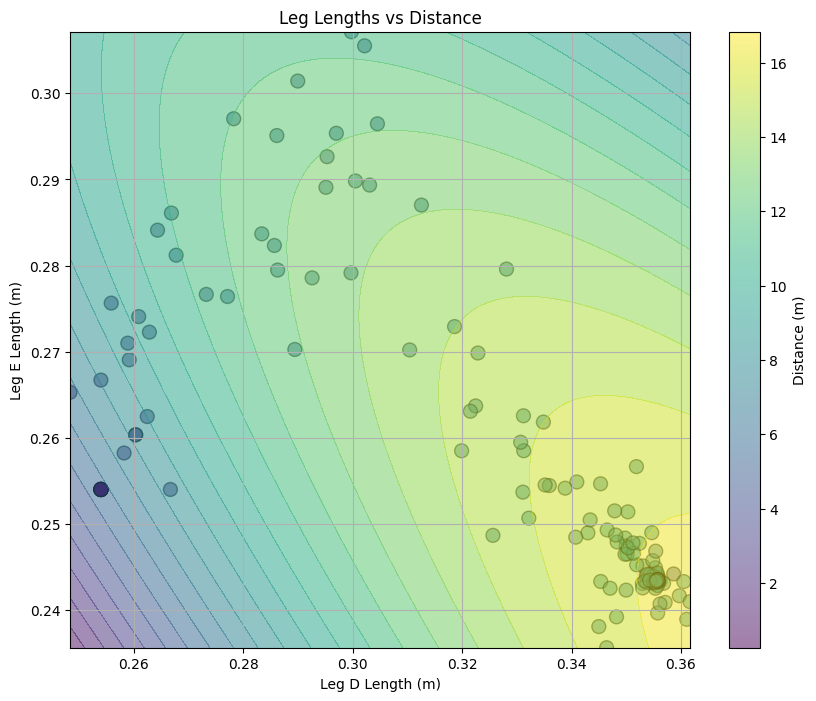

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


d_len_vals = leg_lengths[:, 3]  # Leg D
e_len_vals = leg_lengths[:, 4]  # Leg E

# Reshape for sklearn
X = np.column_stack((d_len_vals, e_len_vals))  # Feature matrix (Leg D and Leg E)
y = dists  # Target values (Distances)

# Degree of the polynomial (e.g., 2 for quadratic, 3 for cubic)
poly = PolynomialFeatures(degree=2)  # Adjust degree for higher-order polynomials

# Transform the data to include polynomial terms
X_poly = poly.fit_transform(X)

# Perform Polynomial Regression
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)

# Predict with the polynomial model
y_poly_pred = poly_reg.predict(X_poly)

# Create a scatter plot with the polynomial regression line
plt.figure(figsize=(10, 8))
scatter = plt.scatter(d_len_vals, e_len_vals, c=dists, cmap='viridis', s=100, edgecolor='k', alpha=0.5)
plt.xlabel("Leg D Length (m)")
plt.ylabel("Leg E Length (m)")
plt.title("Leg Lengths vs Distance")

# Create a meshgrid for plotting the polynomial regression surface
x_vals_poly = np.linspace(min(d_len_vals), max(d_len_vals), 100)
y_vals_poly = np.linspace(min(e_len_vals), max(e_len_vals), 100)
x_grid_poly, y_grid_poly = np.meshgrid(x_vals_poly, y_vals_poly)

# Prepare the meshgrid for polynomial prediction
grid_poly = poly.transform(np.column_stack((x_grid_poly.ravel(), y_grid_poly.ravel())))
z_grid_poly = poly_reg.predict(grid_poly).reshape(x_grid_poly.shape)

# Plot the polynomial regression surface (as a contour plot)
plt.contourf(x_grid_poly, y_grid_poly, z_grid_poly, levels=20, cmap='viridis', alpha=0.5)

# Add color bar for the distances
plt.colorbar(scatter, label="Distance (m)")

plt.grid(True)
plt.show()


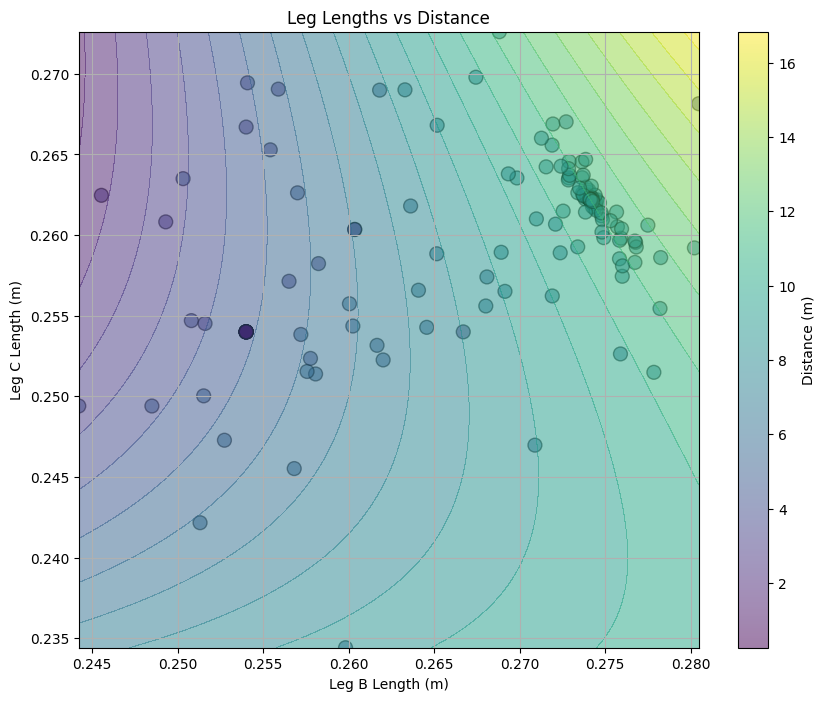

In [124]:
b_len_vals = leg_lengths[:, 1]  # Leg B
c_len_vals = leg_lengths[:, 2]  # Leg C

# Reshape for sklearn
X = np.column_stack((b_len_vals, c_len_vals))  # Feature matrix (Leg D and Leg E)
y = dists  # Target values (Distances)

# Degree of the polynomial (e.g., 2 for quadratic, 3 for cubic)
poly = PolynomialFeatures(degree=2)  # Adjust degree for higher-order polynomials

# Transform the data to include polynomial terms
X_poly = poly.fit_transform(X)

# Perform Polynomial Regression
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)

# Predict with the polynomial model
y_poly_pred = poly_reg.predict(X_poly)

# Create a scatter plot with the polynomial regression line
plt.figure(figsize=(10, 8))
scatter = plt.scatter(b_len_vals, c_len_vals, c=dists, cmap='viridis', s=100, edgecolor='k', alpha=0.5)
plt.xlabel("Leg B Length (m)")
plt.ylabel("Leg C Length (m)")
plt.title("Leg Lengths vs Distance")

# Create a meshgrid for plotting the polynomial regression surface
x_vals_poly = np.linspace(min(b_len_vals), max(b_len_vals), 100)
y_vals_poly = np.linspace(min(c_len_vals), max(c_len_vals), 100)
x_grid_poly, y_grid_poly = np.meshgrid(x_vals_poly, y_vals_poly)

# Prepare the meshgrid for polynomial prediction
grid_poly = poly.transform(np.column_stack((x_grid_poly.ravel(), y_grid_poly.ravel())))
z_grid_poly = poly_reg.predict(grid_poly).reshape(x_grid_poly.shape)

# Plot the polynomial regression surface (as a contour plot)
plt.contourf(x_grid_poly, y_grid_poly, z_grid_poly, levels=20, cmap='viridis', alpha=0.5)

# Add color bar for the distances
plt.colorbar(scatter, label="Distance (m)")

plt.grid(True)
plt.savefig("Figures/C_vs_B_distance.png")

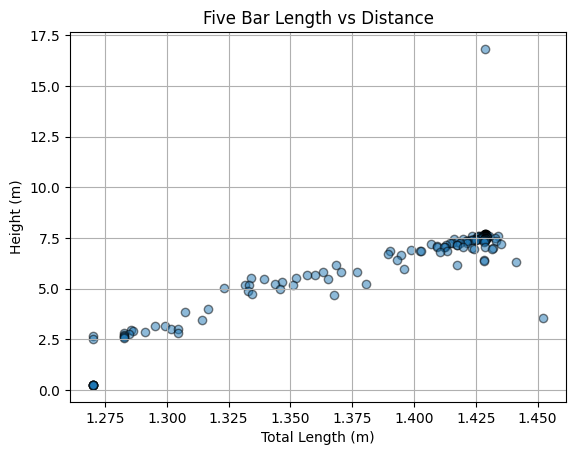

In [123]:
legs_sum = np.sum(leg_lengths,axis=1)

# plt.plot(legs_sum,dists)
plt.scatter(legs_sum, dists, edgecolor='k', alpha=0.5)
plt.xlabel("Total Length (m)")
plt.ylabel("Height (m)")
plt.title("Five Bar Length vs Distance")
plt.grid(True)
plt.savefig("Figures/5bar_total_len_vs_distance.png")

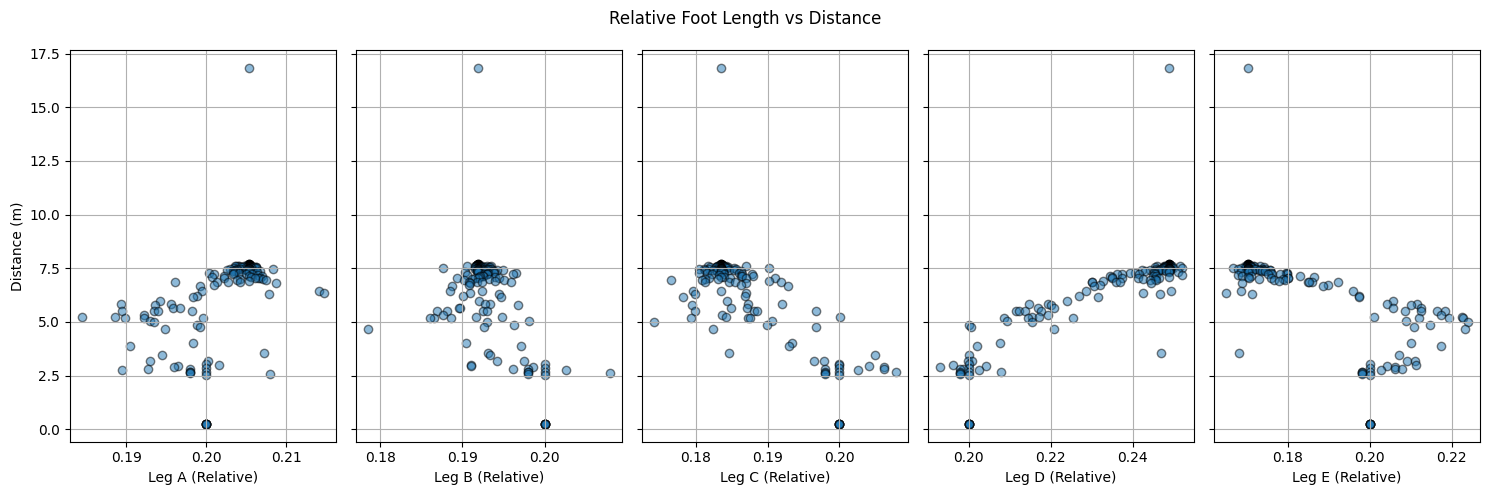

In [122]:
relative_leg_lengths = leg_lengths / legs_sum[:, np.newaxis]

num_legs = leg_lengths.shape[1]  # Number of legs
fig, axs = plt.subplots(1, num_legs, figsize=(15, 5), sharey=True)

# Plot each leg's relative length vs distance
for i in range(num_legs):
    axs[i].scatter(relative_leg_lengths[:, i], dists, edgecolor='k', alpha=0.5)
    axs[i].set_xlabel(f"Leg {chr(65+i)} (Relative)")
    axs[i].grid(True)

# Shared y-axis label and title
axs[0].set_ylabel("Distance (m)")
fig.suptitle("Relative Foot Length vs Distance")
plt.tight_layout()
plt.savefig("Figures/relative_foot_len_vs_distance.png")

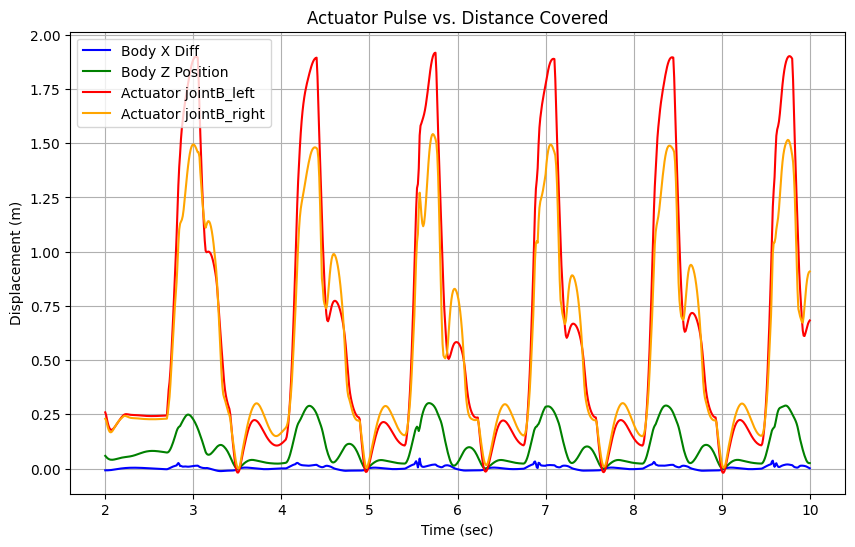

In [121]:
# Compute the difference for body_x and get the z position for body_z
body_x = np.diff(bestModel.simData['qpos'][DATA_TRUNCATE-1:, 0])  # Diff of body_x
body_z = bestModel.simData['qpos'][DATA_TRUNCATE:, 1]  # Z position

body_z+= np.abs(np.min(body_z))

# Extract actuator values based on the indices in act_idxs
act1 = bestModel.simData['qpos'][DATA_TRUNCATE:, act_idxs[0]]
act2 = bestModel.simData['qpos'][DATA_TRUNCATE:, act_idxs[1]]

act2 = np.abs((act2.max()) - act2)

# Plot each variable separately, ensuring the time values align
plt.figure(figsize=(10, 6))

# Plot body_x (difference in X position)
plt.plot(bestModel.simData['time'][DATA_TRUNCATE:], body_x, label="Body X Diff", color='blue')

# Plot body_z (Z position)
plt.plot(bestModel.simData['time'][DATA_TRUNCATE:], body_z, label="Body Z Position", color='green')

# Plot actuator 1
plt.plot(bestModel.simData['time'][DATA_TRUNCATE:], act1, label=f"Actuator {act_names[0]}", color='red')

# Plot actuator 2
plt.plot(bestModel.simData['time'][DATA_TRUNCATE:], act2, label=f"Actuator {act_names[2]}", color='orange')

# Labeling the plot
plt.xlabel("Time (sec)")
plt.ylabel("Displacement (m)")
plt.title("Actuator Pulse vs. Distance Covered")
plt.grid(True)
plt.legend()

# Show the plot
plt.savefig("Figures/Pulse_vs_distance_covered.png")


## Comparing with Prototype Data

In [ ]:
# Define the root directory
exp_data_loc = "./data/Prototype"

# Dictionary to store lists of DataFrames per folder
folder_dfs = {}

# Walk through all subfolders and files
for folder, _, files in os.walk(exp_data_loc):
    folder_name = os.path.basename(folder)
    dfs = []

    for file in files:
        # Process only .csv files
        if file.endswith(".csv"):
            file_path = os.path.join(folder, file)

            # Read the file and remove quotes from each line
            with open(file_path, 'r') as f:
                lines = [line.strip().strip('"') for line in f]

            # Skip the first row and create a cleaned string
            cleaned_data = "\n".join(lines[1:])  # Remove the first row with unnecessary info

            # Create a DataFrame from the cleaned string
            df = pd.read_csv(io.StringIO(cleaned_data), skiprows=1, header=None)

            # Add correct headers
            df.columns = ['t', 'x', 'y']

            # Ensure all columns are numeric
            df['t'] = pd.to_numeric(df['t'], errors='coerce')
            df['x'] = pd.to_numeric(df['x'], errors='coerce')
            df['y'] = pd.to_numeric(df['y'], errors='coerce')

            # Drop rows with NaN values
            df = df.dropna()

            # If valid rows exist, add to the list
            if not df.empty:
                dfs.append(df)

    # If DataFrames are found for this folder, add to the dictionary
    if dfs:
        folder_dfs[folder_name] = dfs

# Print out the summary of DataFrames found
for folder_name, dfs in folder_dfs.items():
    print(f"Folder {folder_name}: {len(dfs)} CSV files processed.")


Folder 20: 3 CSV files processed.
Folder 22: 3 CSV files processed.
Folder 25: 3 CSV files processed.


In [45]:
folder_dfs.keys()

dict_keys(['20', '22', '25'])

In [46]:
experimental_params = {
    "20": (0.1, 0.061, 0.057, 0.055, 0.056, 0.051), # k,A,B,C,D,E (from mm)
    "22": (0.1, 0.059, 0.056, 0.053, 0.062, 0.050), # k,A,B,C,D,E (from mm)
    "25": (0.1, 0.057, 0.054, 0.051, 0.070, 0.048) # k,A,B,C,D,E (from mm)
}

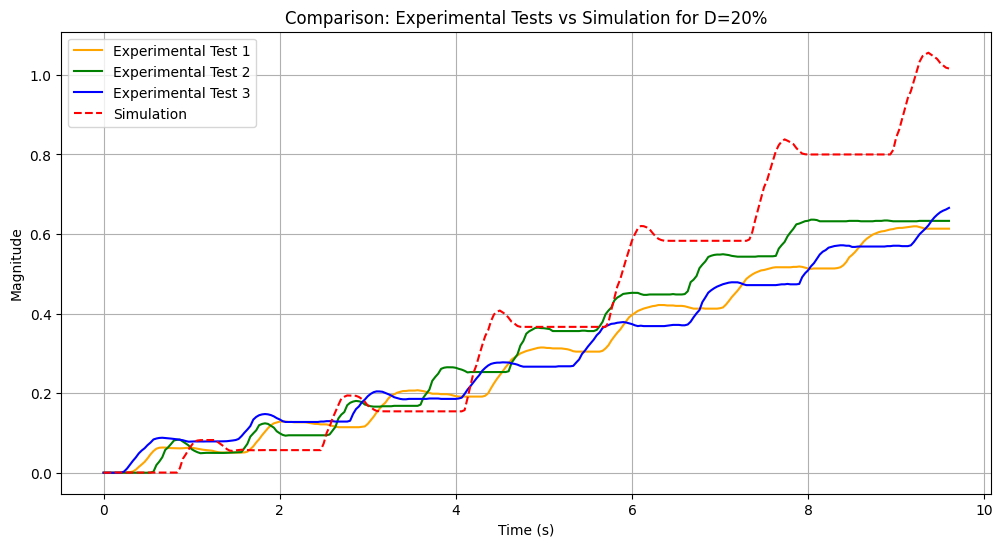

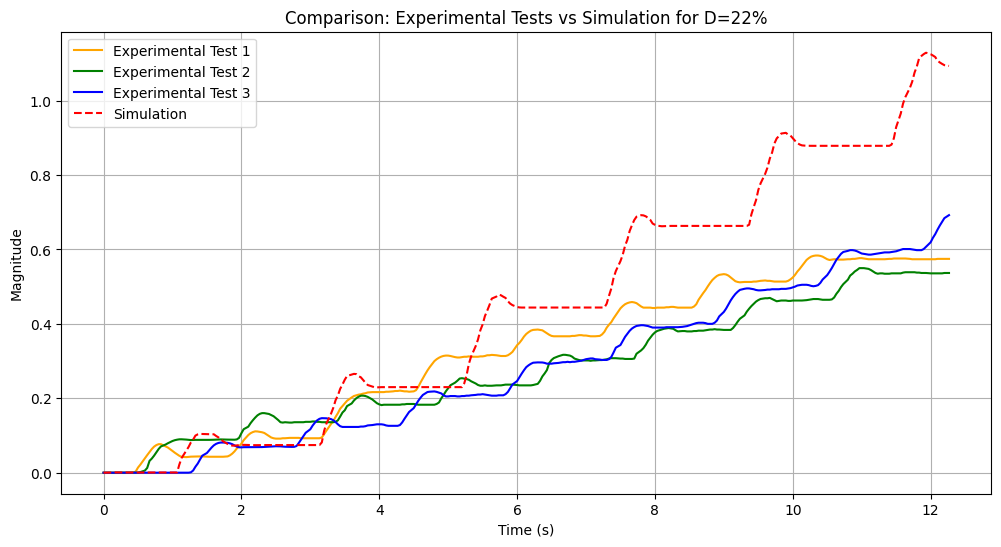

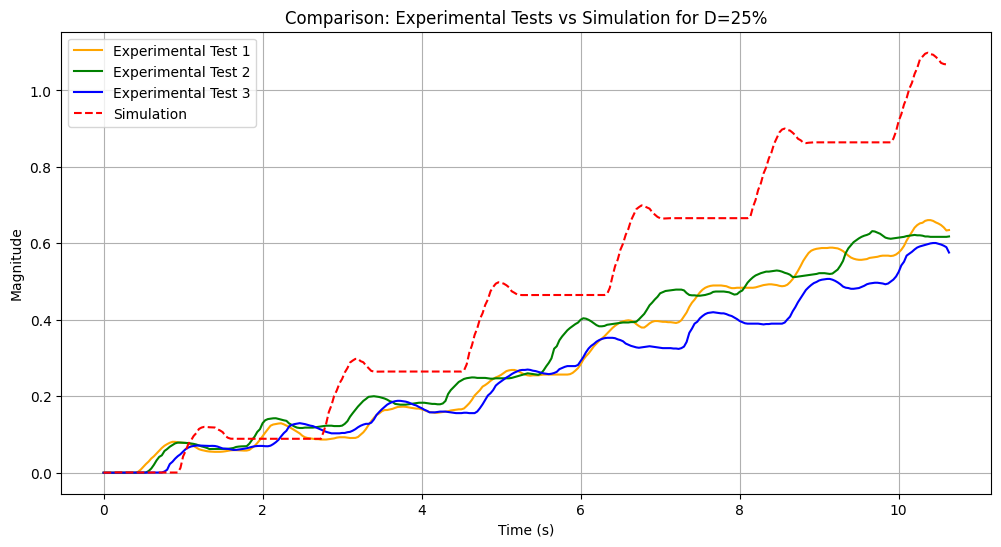

In [118]:
from functools import partial

def process_experimental_data(df):
    """Process a single experimental dataset, starting from zero using the first value."""
    t = df["t"].values
    x = df["x"].values - df["x"].values[0]
    y = df["y"].values - df["y"].values[0]
    return t, np.sqrt(np.square(x) + np.square(y))

def downsample(data, target_length):
    """Downsample the data to match the target length."""
    if len(data) > target_length:
        return data[np.linspace(0, len(data)-1, target_length, dtype=int)]
    return data[:target_length]

def plot_data(time, exp_mags, sim_mag, folder_display_name):
    """Plot experimental and simulation magnitudes."""
    plt.figure(figsize=(12, 6))
    colors = ["orange", "green", "blue"]
    for i, mag in enumerate(exp_mags):
        plt.plot(time, mag, label=f"Experimental Test {i+1}", color=colors[i])
    
    plt.plot(time, sim_mag, label="Simulation", linestyle="--", color="red")
    
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Magnitude")
    plt.title(f"Comparison: Experimental Tests vs Simulation for {folder_display_name}")
    plt.grid(True)
    plt.savefig(f"Figures/{folder_display_name.strip("=%")}_vs_simulation.png")

simValidation = {
    "mag":[],
    "time":[]
}

# Main processing loop
for folder_name, dfs in folder_dfs.items():
    if len(dfs) != 3 or folder_name not in experimental_params:
        print(f"Skipping folder {folder_name}: insufficient data or missing parameters.")
        continue

    # Process experimental data
    exp_data = [process_experimental_data(df) for df in dfs]
    exp_times, exp_mags = zip(*exp_data)

    # Run simulation
    expSim = run_sim(experimental_params[folder_name], render=False)
    qpos_data = expSim.simData['qpos'][DATA_TRUNCATE:, :2]
    sim_mag = np.sqrt(np.sum(np.square(qpos_data - qpos_data[0]), axis=1))  # Start simulation at zero

    simValidation["mag"].append(sim_mag)
    simValidation["time"].append(expSim.simData['time'][DATA_TRUNCATE:])

    # Determine target length and downsample
    target_length = min(len(time) for time in exp_times)
    downsample_func = partial(downsample, target_length=target_length)
    
    exp_times = list(map(downsample_func, exp_times))
    exp_mags = list(map(downsample_func, exp_mags))
    sim_mag = downsample_func(sim_mag)

    # Plot results
    plot_data(exp_times[0], exp_mags, sim_mag, f"D={folder_name}%")

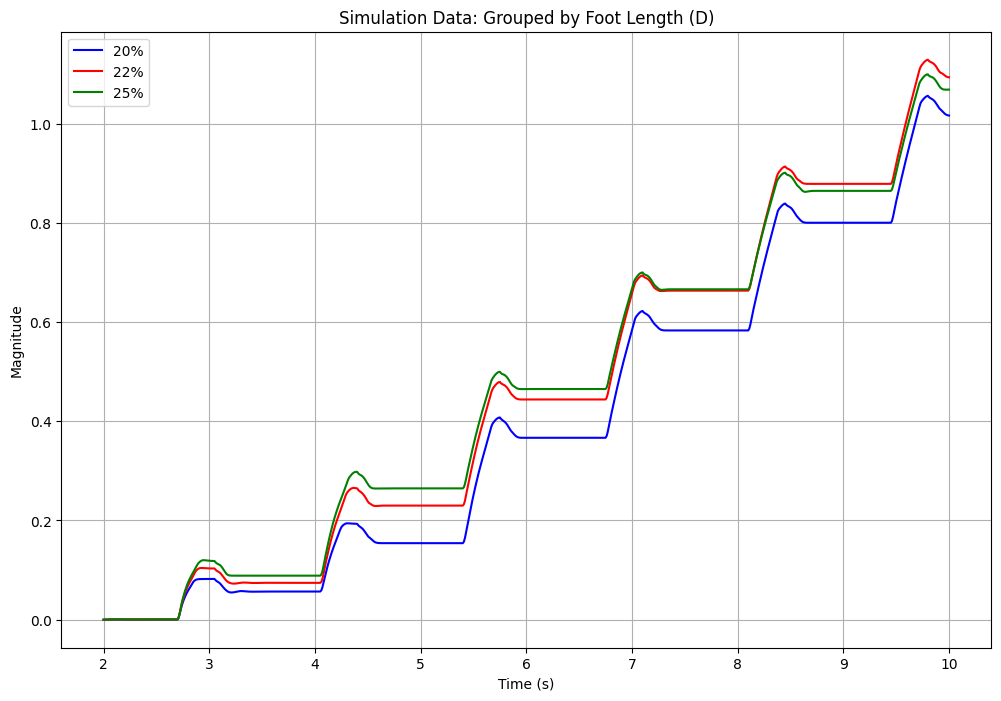

In [115]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(simValidation["time"])[0], np.array(simValidation["mag"]).T[:,0], color="blue")
plt.plot(np.array(simValidation["time"])[0], np.array(simValidation["mag"]).T[:,1], color="red")
plt.plot(np.array(simValidation["time"])[0], np.array(simValidation["mag"]).T[:,2], color="green")

plt.legend(["20%","22%","25%"])
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.title("Simulation Data: Grouped by Foot Length (D)")
plt.grid(True)
plt.savefig("Figures/simulation_validation_reproduction.png")

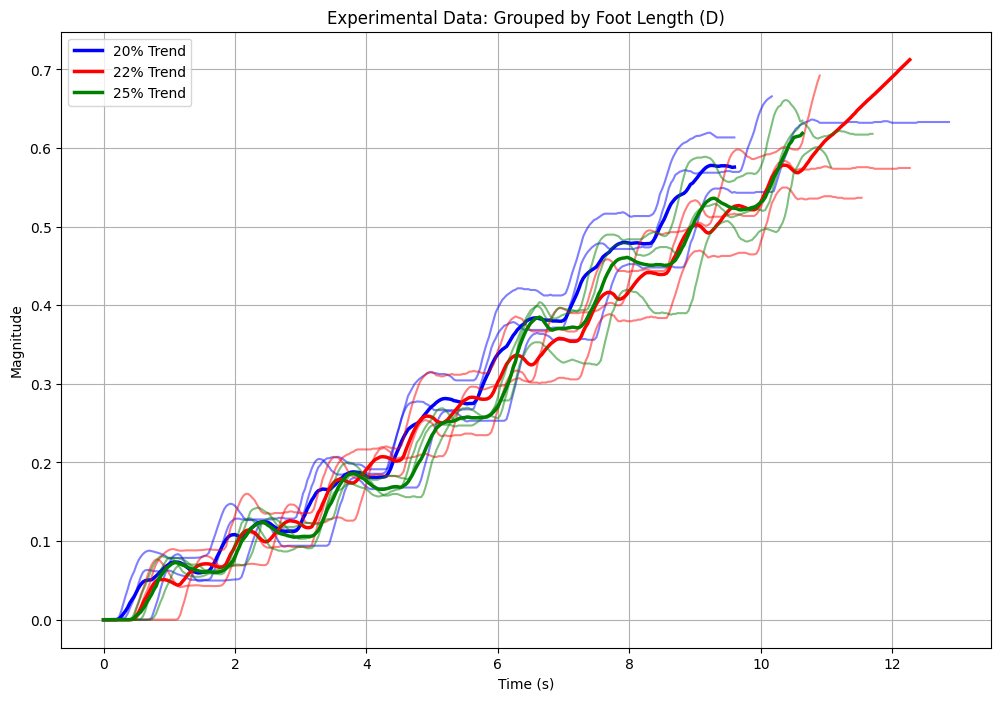

In [148]:
from scipy.interpolate import interp1d

def align_time_series(t, magnitudes, common_t):
    """Align the magnitude data to a common time series using interpolation."""
    interp_func = interp1d(t, magnitudes, kind='linear', fill_value="extrapolate")
    return interp_func(common_t)

def plot_grouped_data(folder_dfs):
    """Plot t vs sqrt(x^2 + y^2) for all DataFrames, grouped by Foot Length name."""
    plt.figure(figsize=(12, 8))
    
    # Define a list of legible colors
    colors = ["blue", "red", "green"]
    
    for idx, (folder_name, dfs) in enumerate(folder_dfs.items()):
        color = colors[idx % len(colors)]  # Assign a unique color to each folder
        
        all_magnitudes = []
        common_t = None
        
        for df in dfs:
            t, magnitude = process_experimental_data(df)
            
            # Initialize common_t with the first dataset's t
            if common_t is None:
                common_t = t
            # Align current t and magnitude to the common time vector using interpolation
            aligned_magnitude = align_time_series(t, magnitude, common_t)
            
            all_magnitudes.append(aligned_magnitude)
            plt.plot(t, magnitude, color=color, alpha=0.5)  # Lighter lines for individual tests
        
        # Compute and plot the trend line (mean magnitude)
        avg_magnitude = np.mean(all_magnitudes, axis=0)
        plt.plot(common_t, avg_magnitude, color=color, linewidth=2.5, label=f"{folder_name}% Trend")

    # Customize the plot
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Magnitude")
    plt.title("Experimental Data: Grouped by Foot Length (D)")
    plt.grid(True)
    plt.savefig("Figures/experimental_grouped_trend_line.png")

# Call the plotting function
plot_grouped_data(folder_dfs)


In [56]:
_=[run_sim(experimental_params[key], render=True).renderMedia(save=True,codec="mp4",title=f"Videos/Physical_Model_Reproduction/D_{key}_Leg_Sim") for key in experimental_params.keys()]

Media saved to Physical_Model_Reproduction/D_20_Leg_Sim.mp4
Media saved to Physical_Model_Reproduction/D_22_Leg_Sim.mp4
Media saved to Physical_Model_Reproduction/D_25_Leg_Sim.mp4
